# Phenomenological Builder


## Modules

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as sg
import pandas as pd
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec  
import random
import time

## Resample 

In [3]:
def resample(t,h,fs):
    """
    Interpolate array h to the fs sampling frequency.
    Input:
        t  - time array, in seconds
        h  - strain array to be interpolated
        fs - thi is the new sampling frequency
    Output:
        t1 - time array, after resampling
        h1 - new strain array
    """
    # Quick check
    if len(t)!=len(h):
        print("Error: t and h need to have equal sizes")
        return 0
    # Define new time with fs
    t1 = np.arange(t[0],t[-1],1.0/fs)
    # Interpolation
    tck = interpolate.splrep(t,h,s=0)
    h1  = interpolate.splev(t1,tck,der=0)
   
    return t1, h1,fs

## Graphics

In [4]:
def graphs(h,time,Fm,f,tf):
    def add_colorbar(mappable):
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        import matplotlib.pyplot as plt
        last_axes = plt.gca()
        ax = mappable.axes
        fig = ax.figure
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(mappable, cax=cax)
        cbar.set_label('Amplitude String (1/Hz)',fontsize=12)
        plt.sca(last_axes)
        return cbar

    wnd="hamming"
    # if Fm == 200000:
    #   nfft=4*4096
    #   nperseg=4096
    #   noverlap=4096-512
    # elif Fm ==16384:
    r = 1024
    nfft=4*r
    nperseg=r
    noverlap=r-r/8

    fxx, txx, Sxx = sg.spectrogram(h, Fm, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')

    plt.figure()
    fig,(axs1,axs2) = plt.subplots(1,2,tight_layout = True, figsize=(12,4))
    # plt.suptitle("Spectrogram of the signal (variations of $t_{2}$)",fontsize=16)
    #plt.suptitle("Espectrograma de la señal (variaciones de $t_{2}$)",fontsize=16)
    axs1.plot(time,h,color="darkorange")
    axs1.set_ylabel('$h$')
    axs1.set_xlabel("Time[s]")
    axs1.grid()
    # axs[0,0].text(0.01,500,"$t_{2} = $" + str(t2_1),{'color': 'ivory', 'fontsize': 15})

    z = axs2.pcolormesh(txx, fxx, Sxx,shading="auto",cmap="winter")
    add_colorbar(z)
    #z.set_label('Amplitude String (1/Hz)')
    axs2.plot(tf,f,"r")
    axs2.set_ylabel('Frequency [Hz]')
    axs2.set_xlabel('Time [s]')
    axs2.set_ylim([0,max(f) +100])
    axs2.set_xlim(min(txx),max(txx))

## Phen Implementation

## New "Sigmoid" "Function"

In [5]:
# Define logistic function
def Pseudolog(x,b0,b1):
    lin = b0 + b1*x   
    num = np.exp(lin)
    den = np.exp(lin) + 1
    return 1 - num/den
# # Define t
# fs   = 16384
# Ts   = 1/fs
# # Define signal duration
# Tfin = 1.0
# t    = np.arange(0,Tfin,Ts)
# # Create Logistic
# b0 = -34 # Varia de acuerdo a la duracion de la señal h(t)
# b1 = 40 # Queda constante
# W  = Pseudolog(t,b0,b1)

# # Scatter plot of the data and a logistic function
# plt.plot(t, W, ':r' , label='w'  , linewidth=2)
# plt.xlabel("t")
# plt.ylabel("w(t)")
# plt.show()

## Implementación

In [25]:
def Imp(duration,f_0,f_1,f_driver,Seed):
    Fm    = 200000 #200000
    t_ini = 0.0
    t_2   = duration +0.5
    Q     = 10
    dt    = 1/Fm
    t_s   = np.arange(t_ini,duration,dt)
    f     = np.zeros(len(t_s))    # Set memory to get the frequency
    p_2   = np.zeros(len(t_s))  # Set memory to p_2
    w     = np.zeros(len(t_s))    # Set memory to angular frequency    
    for i in range(0,len(t_s)):
        p_1    =  f_1 - f_0 
        p_3    =  t_2 - t_ini
        ab     = (2*t_2-t_ini-1)*(1-t_ini)
        p_2[i] = t_s[i]-t_ini
        f[i]   = f_0 + 2*p_1*p_3*(p_2[i])/(ab) - p_1*(p_2[i])**2/(ab)
        w[i]   = 2*np.pi*f[i]
    slope = f[(len(t_s) - 1)] - f[0] / duration
    #return t_s,f,w,slope
    # ==============================================
    # Delta implementation
    N    = np.arange(t_ini,duration,dt) 
    n    = int(f_driver/(duration-t_ini))
    rng  = np.random.default_rng(seed = Seed)
    t_n1 = rng.uniform(t_ini,duration,n) #Set the uniform distribution of t_n
    t_n  = np.sort(t_n1)       # t_n in progresive order
    t_s  = np.arange(t_ini,duration,dt) #Time in the inicial interval (simple)
    a_n1 = rng.uniform(-1,1,n) 
    a_n1 = a_n1 *t_n
    a    = np.zeros((len(t_s)))
    for i in range(0,len(t_s)):
        for j in range(0,n):
            if t_s[i]-t_n[j]<=0 and t_s[i]-t_n[j]>=-15e-6 :     
                #print("-")
                a[i] = a_n1[j]
                i+=1
    # Model            
    h_t = np.zeros(len(t_s))
    h   = np.zeros(len(t_s))
    # h_t[0] = 0
    # h[0] = 0
    def F(a,h_t,h,w):
        return a - (w/Q)*h_t - (w**2)*h
    for i in range(1,len(t_s)):
        h_t[i] = h_t[i-1] + F(a[i-1],h_t[i-1],h[i-1],w[i-1])*dt
        h[i] = h[i-1] + h_t[i-1]*dt
    h   = h/max(abs(h))
    # ===================================
    # Resample 
    t_res,h_res,nfs = resample(t_s,h,16384)
    #print(h_res.shape)
    #print(t_res.shape)
    #print(t_s)
    #====================================
    # Graphs
    #graphs(h_res,t_res,nfs,f,t_s) # Esta si va mostrando sin la "sigmoid function"
    #graphs(h,t_s,Fm,f,t_s)
    #====================================
    # Pseudo Sigmoid Function
    t_A = np.linspace(0.0,1.0,len(t_res))
    #Pseudo = PseudoSigFun(t_res)
    Pseudo = Pseudolog(t_A,-34,40)
    #print(Pseudo.shape)
    h_sig = h_res*Pseudo
    #====================================
    # New Graphs
    graphs(h_sig,t_res,nfs,f,t_s)
    return h_res,slope,t_res,f
#    return a, w, Q, t_s, dt,f

## CALL the function

<Figure size 640x480 with 0 Axes>

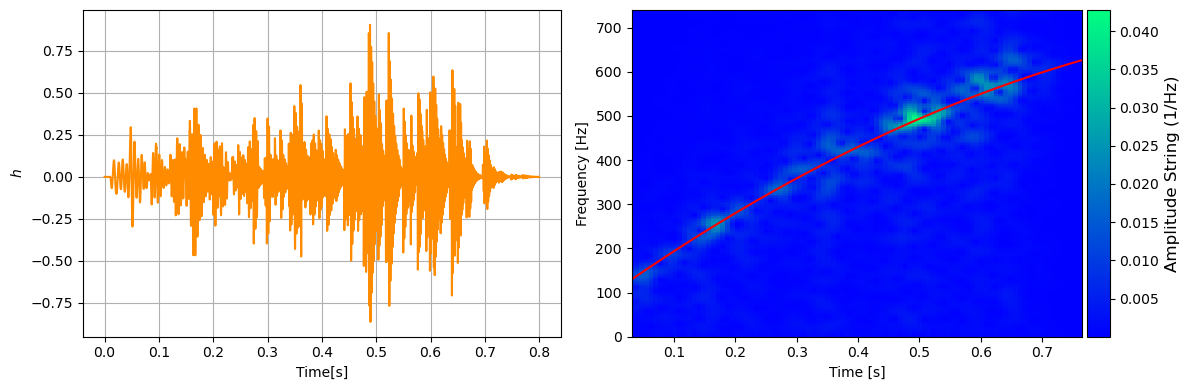

In [7]:
# Call the function Imp(Duration,f_0,f_1,f_driver,seed)
Dur = 0.8
H,S,Time,F = Imp(Dur,100,700,200,8)

<Figure size 432x288 with 0 Axes>

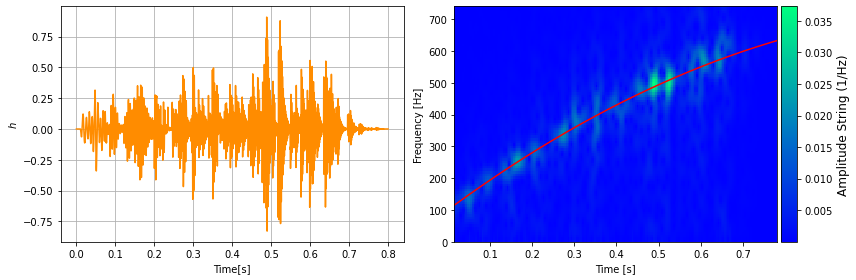

In [ ]:
Dur = 0.8
H,S,Time,F = Imp(Dur,100,700,200,8)

<Figure size 432x288 with 0 Axes>

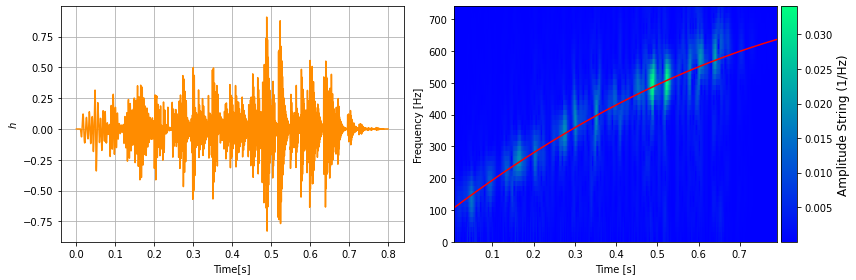

In [ ]:
H,S,Time,F = Imp(Dur,100,700,200,8)

## Generador del dataset

In [ ]:
# Generamos Dataset
Dat = pd.DataFrame()


# Generar un listado de datos que son necesarios o usos

f_0     = np.linspace(100,400,200) 
f_1     = np.linspace(500,2000,200)
f_drive = np.arange(100,200,1)
Duration= np.linspace(0.3,1.5,200)

# print(f_0)
# print(f_1)
print(random.choices(f_drive))

[139]


In [ ]:

f_0     = np.linspace(100,400,200) 
f_1     = np.linspace(500,1500,200)
f_drive = np.arange(100,200,1)
Duration= np.linspace(0.3,1.5,200)



#slowly rotating
#slow_Dur = np.linspace(1.0,1.5,500)
slow_f_0 = f_0
slow_f_1 = f_1

#Moderate rotating
moder_Dur = np.linspace(1.0,1.8,500)
moder_f_0 = f_0
moder_f_1 = f_1


#Rapidly rotating
#rapid_Dur = np.linspace(1.0,1.8,500)
rapid_f_0 = f_0
rapid_f_1 = f_1



slow_Dur = np.linspace(0.8,1.2,500)
rapid_Dur= np.linspace(0.3,0.5,500)
moder_Dur= np.linspace(0.5,0.8,500)


for i in range(0,20):
    f=f_0[random.randint(0,199)]
    f1=f_1[random.randint(0,199)]
    H,S,Time,F = Imp(slow_Dur[random.randint(0,499)], f,f1, 200, 8)
    print("Slope",S,"f_0",f,"f_1",f1)

## Slowly Rotating

In [45]:
# Generate a folder to save all the data 
# Desktop/CCSNe_Phen/H9_Slope1800_f0(127.14)_f1(1982.21).csv
import os

mainpath = r'C:\Users\PC\Desktop\CCSNe_Phen'
try:
    os.chdir(mainpath)
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except FileExistsError:
    print("The directory: {0}",path,"Already exist")
print(os.getcwd())  
# Create a folder to save all the rapidly rotating data
print(os.getcwd())
print(os.getcwd() + "\\Slow\\")


path = os.getcwd() + "\\Slow\\"  #"C:\\Users\\PC\\Desktop\\Tesis\\Fen_tiz\\Images\\"

try:
    os.mkdir(path)
    print("The directory: {0}",path,"Created")
except FileExistsError:
    print("The directory: {0}",path,"Already exist")



C:\Users\PC\Desktop\CCSNe_Phen
C:\Users\PC\Desktop\CCSNe_Phen\Slow\
The directory: {0} C:\Users\PC\Desktop\CCSNe_Phen\Slow\ Created


In [ ]:
# Primera forma de obtener la data
slow_Dur = np.linspace(0.3,0.5,200)
slow_f_0 = np.linspace(100,150,200)
slow_f_1 = 1000#np.linspace(1980,2000,200)
#rapid_Dur = np.linspace(0.35,0.55,200)
for i in range(0,10):
    f=slow_f_0[random.randint(0,199)]
    f1=slow_f_1#[random.randint(0,199)]
    H,S,Time,F = Imp(slow_Dur[random.randint(0,199)], f,f1, 200, 8)
    S = int(S)
    f = "%.2f" % f
    f1 = "%.2f" % f1
    dat = pd.DataFrame()
    dat["H"] = H
    dat.to_csv(path + "run1"+f'H{i}'"_Slope"f"{S}""_f0("f"{f})""_f1("f"{f1}).csv")
    print("Slope",S,"f_0",f,"f_1",f1)

## Moderate Rotating

In [57]:
# Generate a folder to save all the data 
# Desktop/CCSNe_Phen/H9_Slope1800_f0(127.14)_f1(1982.21).csv
import os

mainpath = r'C:\Users\PC\Desktop\CCSNe_Phen'
try:
    os.chdir(mainpath)
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except FileExistsError:
    print("The directory: {0}",path,"Already exist")
print(os.getcwd())  
# Create a folder to save all the rapidly rotating data
print(os.getcwd())
print(os.getcwd() + "\\Moder\\")


path = os.getcwd() + "\\Moder\\"  #"C:\\Users\\PC\\Desktop\\Tesis\\Fen_tiz\\Images\\"

try:
    os.mkdir(path)
    print("The directory: {0}",path,"Created")
except FileExistsError:
    print("The directory: {0}",path,"Already exist")

# mainpath = path
# try:
#     os.chdir(mainpath)
# except FileNotFoundError:
#     print("Directory: {0} does not exist".format(path))
# except FileExistsError:
#     print("The directory: {0}",path,"Already exist")
# print(os.getcwd())  


C:\Users\PC\Desktop\CCSNe_Phen
C:\Users\PC\Desktop\CCSNe_Phen
C:\Users\PC\Desktop\CCSNe_Phen\Moder\
The directory: {0} C:\Users\PC\Desktop\CCSNe_Phen\Moder\ Already exist


Slope 894 f_0 135.00 f_1 1263.82 Time: 0.691162109375
Slope 923 f_0 121.13 f_1 1298.99 Time: 0.6693115234375
Slope 917 f_0 131.76 f_1 1346.73 Time: 0.6346435546875
Slope 1036 f_0 127.91 f_1 1366.83 Time: 0.74395751953125
Slope 1057 f_0 127.31 f_1 1407.04 Time: 0.72735595703125
Slope 1083 f_0 128.59 f_1 1461.06 Time: 0.70623779296875
Slope 940 f_0 127.84 f_1 1335.43 Time: 0.664794921875
Slope 1045 f_0 134.25 f_1 1473.62 Time: 0.66326904296875
Slope 878 f_0 131.91 f_1 1263.82 Time: 0.6685791015625
Slope 1097 f_0 134.10 f_1 1451.01 Time: 0.7386474609375


<Figure size 640x480 with 0 Axes>

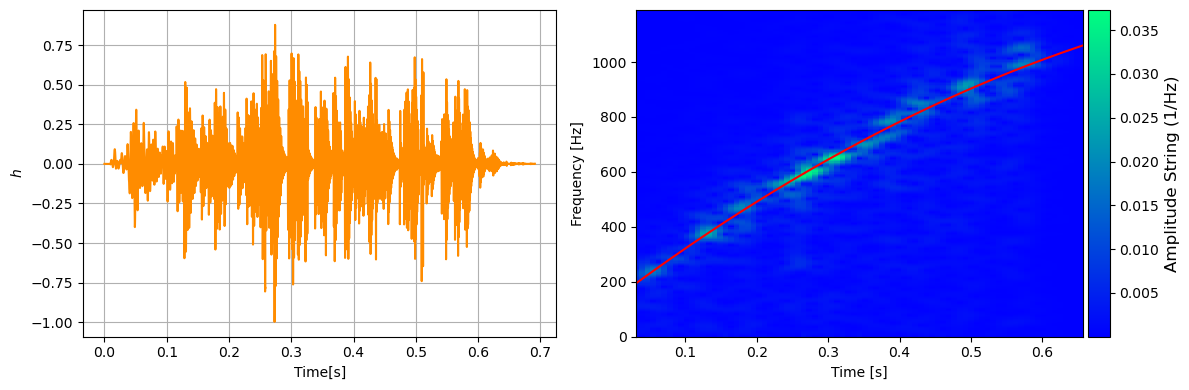

<Figure size 640x480 with 0 Axes>

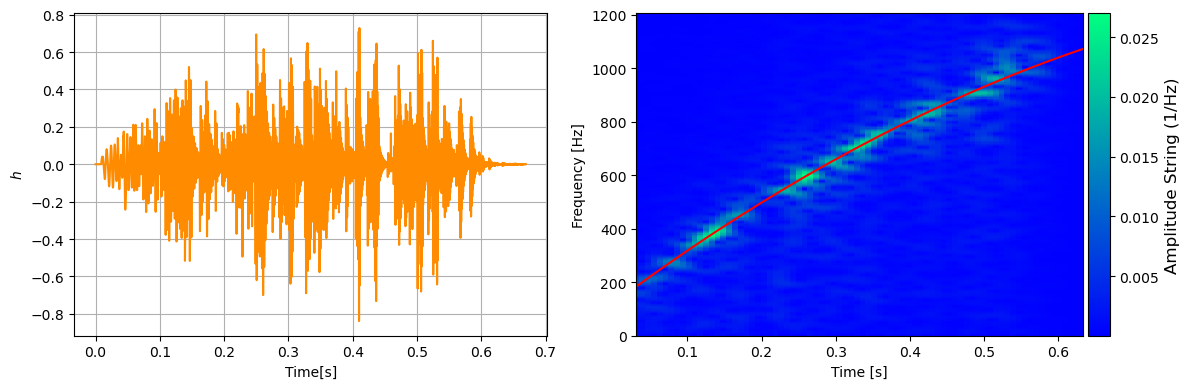

<Figure size 640x480 with 0 Axes>

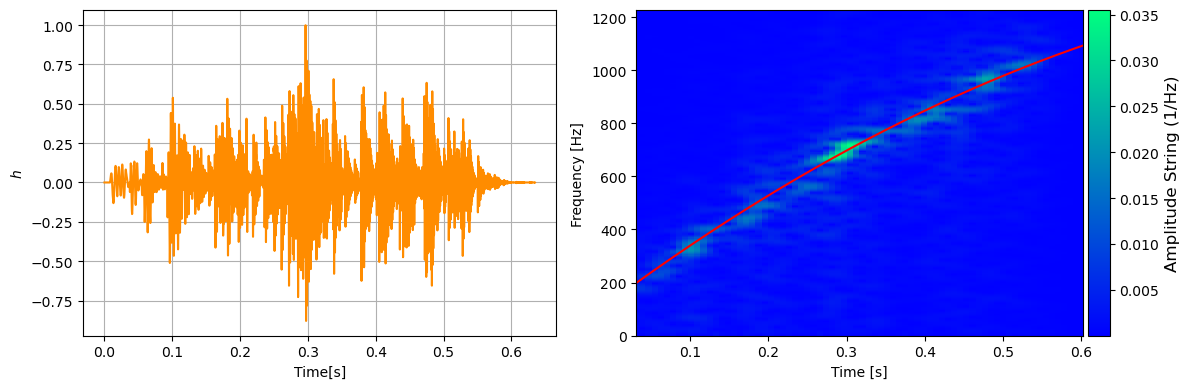

<Figure size 640x480 with 0 Axes>

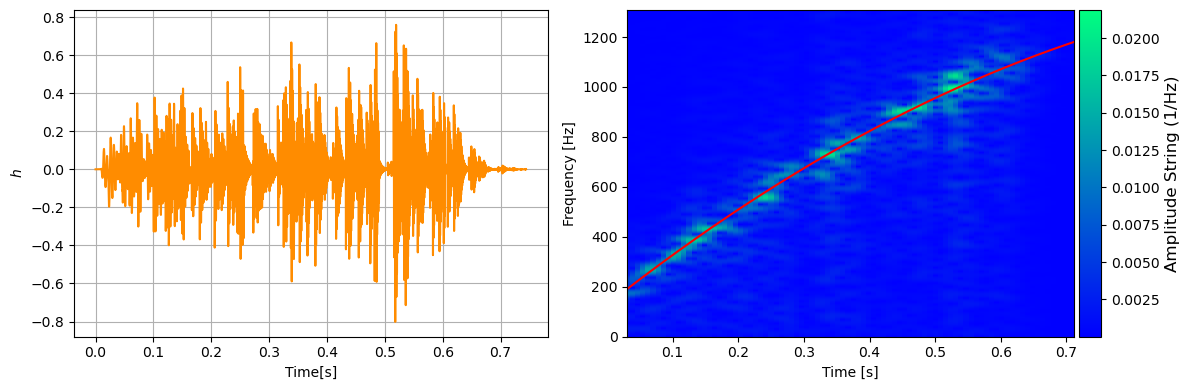

<Figure size 640x480 with 0 Axes>

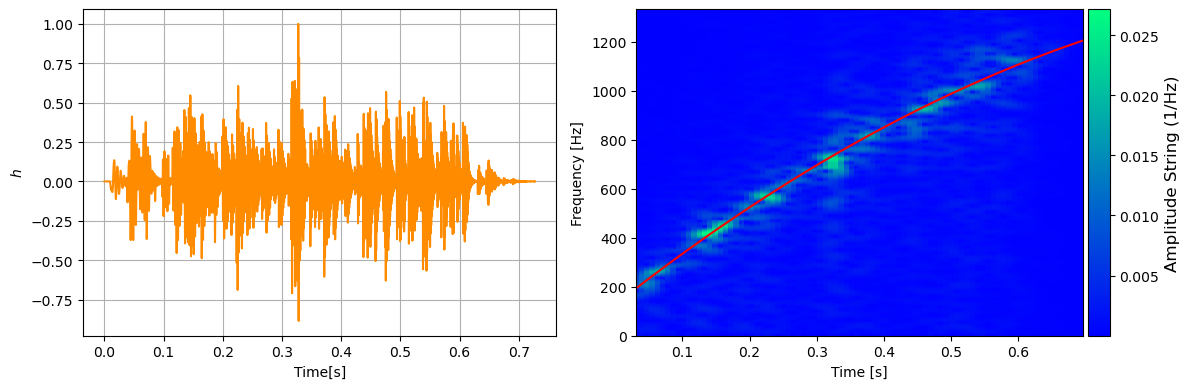

<Figure size 640x480 with 0 Axes>

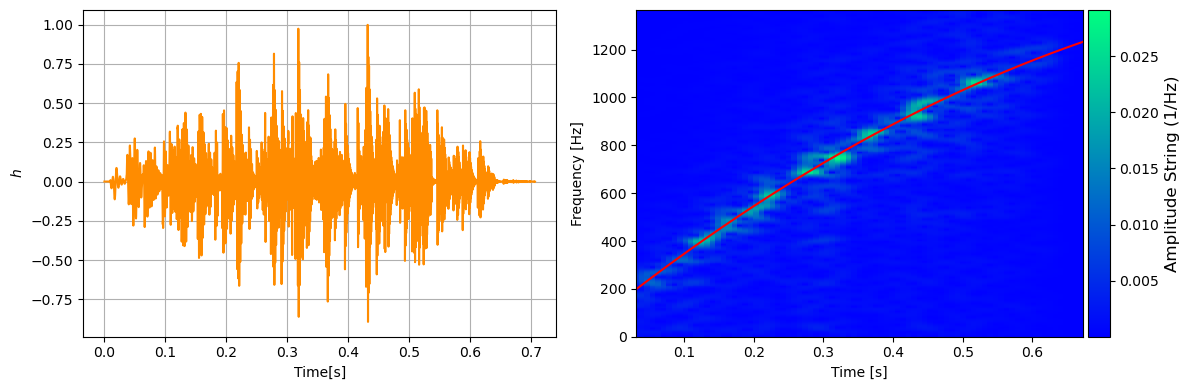

<Figure size 640x480 with 0 Axes>

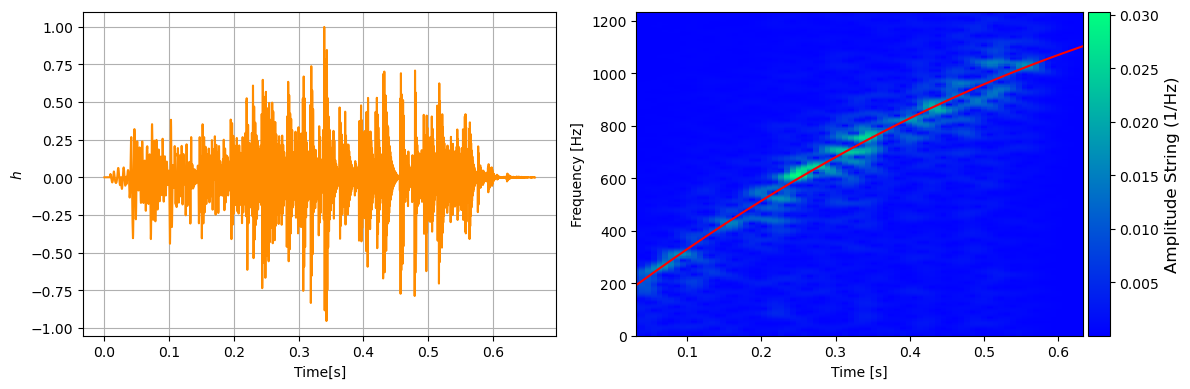

<Figure size 640x480 with 0 Axes>

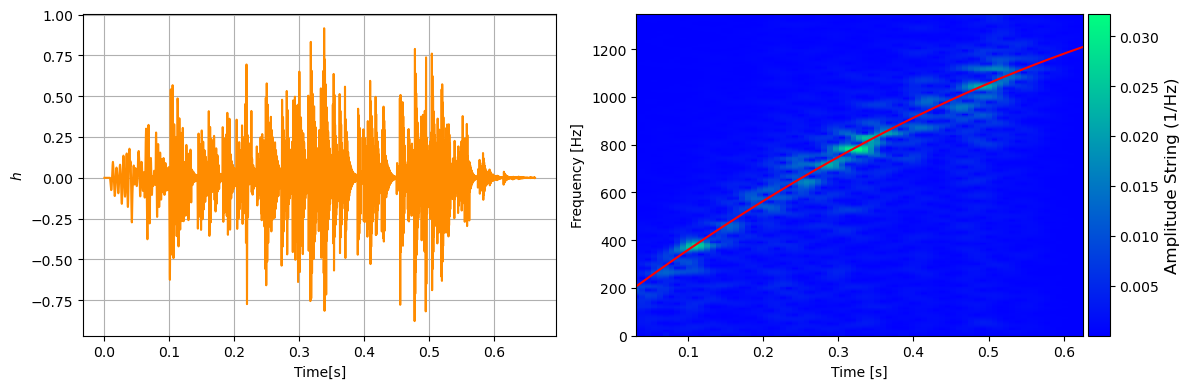

<Figure size 640x480 with 0 Axes>

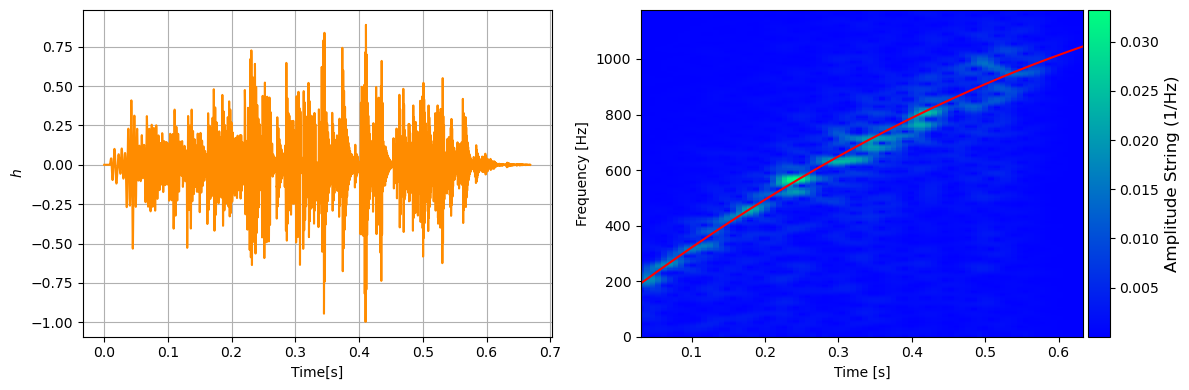

<Figure size 640x480 with 0 Axes>

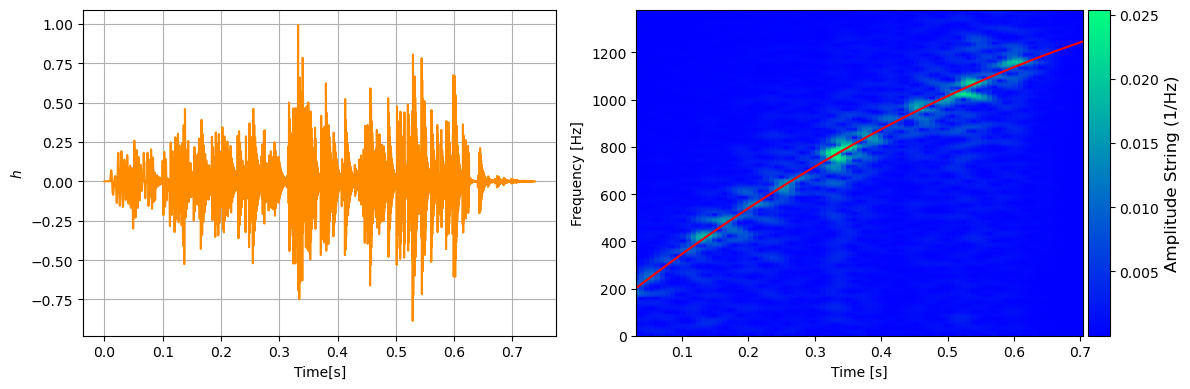

In [65]:
moder_Dur = np.linspace(0.6,0.75,200)
moder_f_0 = np.linspace(120,135,200) 
moder_f_1 = np.linspace(1250,1500,200)

for i in range(0,10):
    f=moder_f_0[random.randint(0,199)]
    f1=moder_f_1[random.randint(0,199)]
    H,S,Time,F = Imp(moder_Dur[random.randint(0,199)], f,f1, 200, 8)
    S = int(S)
    f = "%.2f" % f
    f1 = "%.2f" % f1
    dat = pd.DataFrame()
    dat["H"] = H
    dat.to_csv(path + "run1"+f'H{i}'"_Slope"f"{S}""_f0("f"{f})""_f1("f"{f1}).csv")
    print("Slope",S,"f_0",f,"f_1",f1,"Time:",Time[-1])

Slope 1066 f_0 130.00 f_1 1450.00
Slope 1066 f_0 130.00 f_1 1450.00
Slope 1066 f_0 130.00 f_1 1450.00
Slope 1066 f_0 130.00 f_1 1450.00
Slope 1066 f_0 130.00 f_1 1450.00
Slope 1066 f_0 130.00 f_1 1450.00
Slope 1066 f_0 130.00 f_1 1450.00
Slope 1066 f_0 130.00 f_1 1450.00
Slope 1066 f_0 130.00 f_1 1450.00
Slope 1066 f_0 130.00 f_1 1450.00
       H0_Seed167     H1_Seed168  H2_Seed169  H3_Seed170  H4_Seed171  \
0        0.000000   0.000000e+00    0.000000    0.000000    0.000000   
1        0.000000   0.000000e+00    0.000000    0.000000    0.000000   
2        0.000000  8.646149e-322    0.000000    0.000000    0.000000   
3        0.000000  7.735587e-315    0.000000    0.000000    0.000000   
4        0.000000  4.132121e-308    0.000000    0.000000    0.000000   
...           ...            ...         ...         ...         ...   
11464    0.411884   7.396044e-01   -0.023927   -0.241410    0.062330   
11465    0.479418   6.935453e-01   -0.024413   -0.161157    0.070672   
11466    0.4

<Figure size 640x480 with 0 Axes>

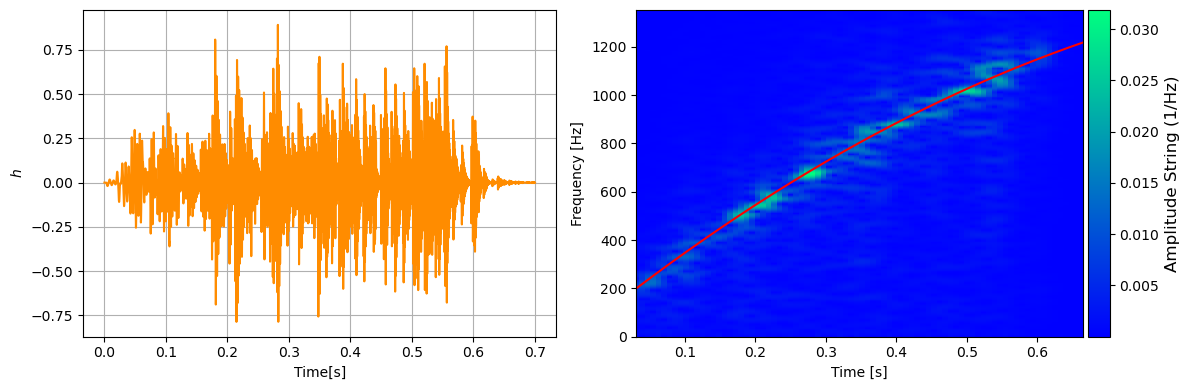

<Figure size 640x480 with 0 Axes>

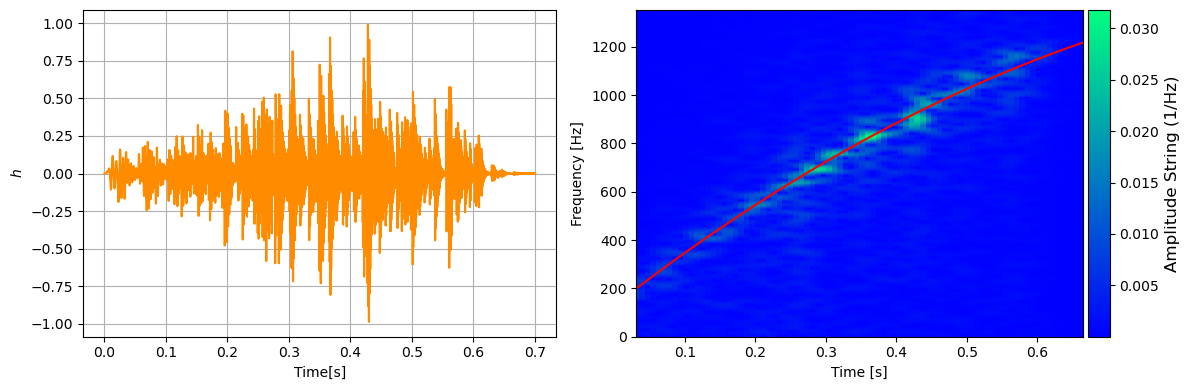

<Figure size 640x480 with 0 Axes>

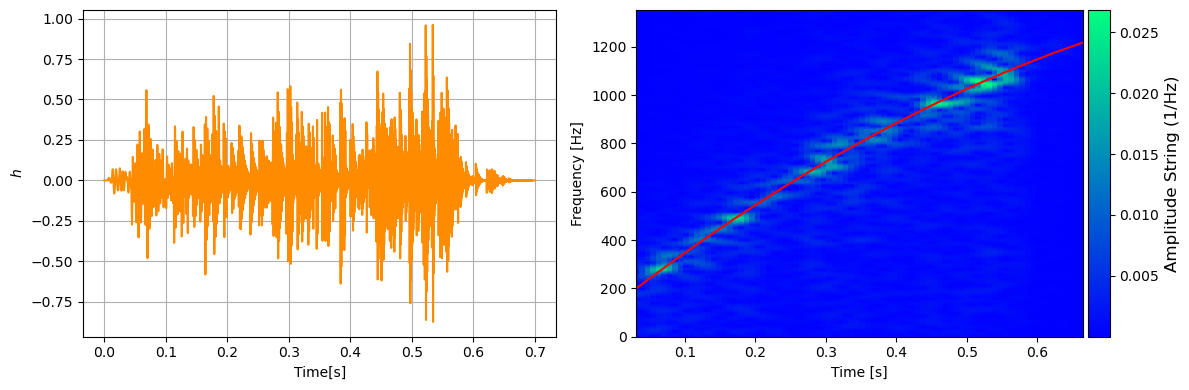

<Figure size 640x480 with 0 Axes>

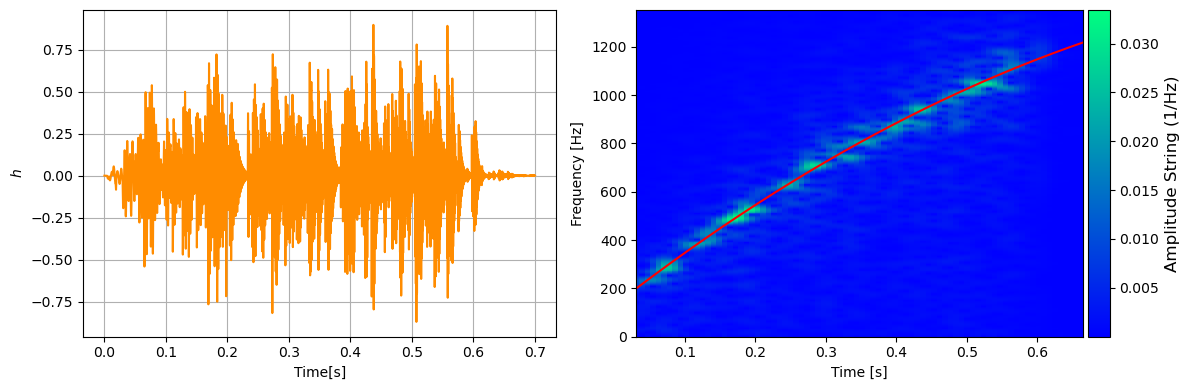

<Figure size 640x480 with 0 Axes>

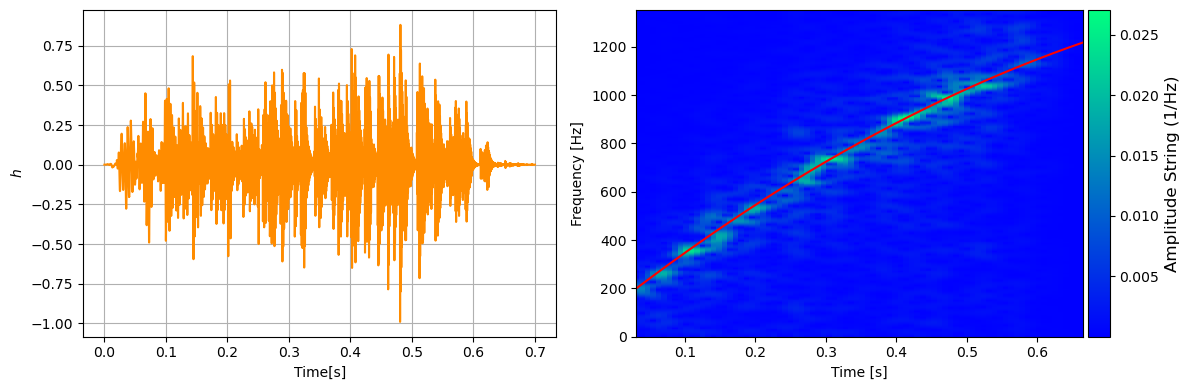

<Figure size 640x480 with 0 Axes>

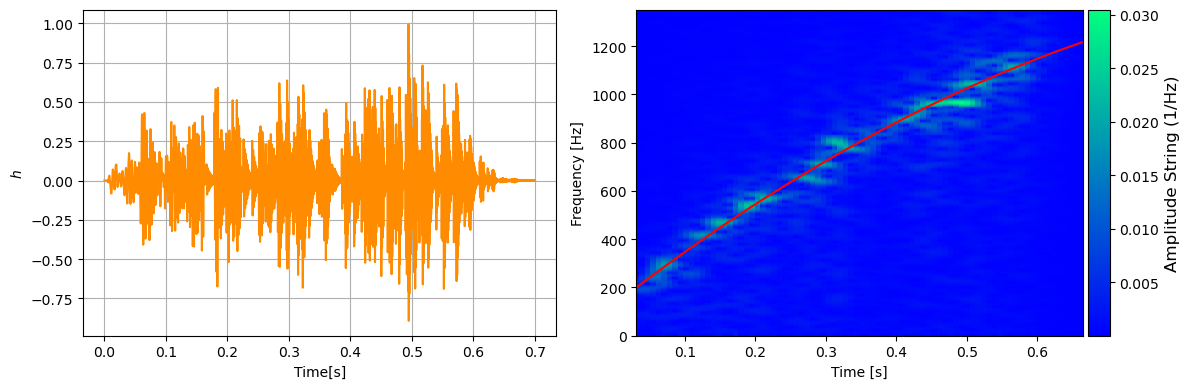

<Figure size 640x480 with 0 Axes>

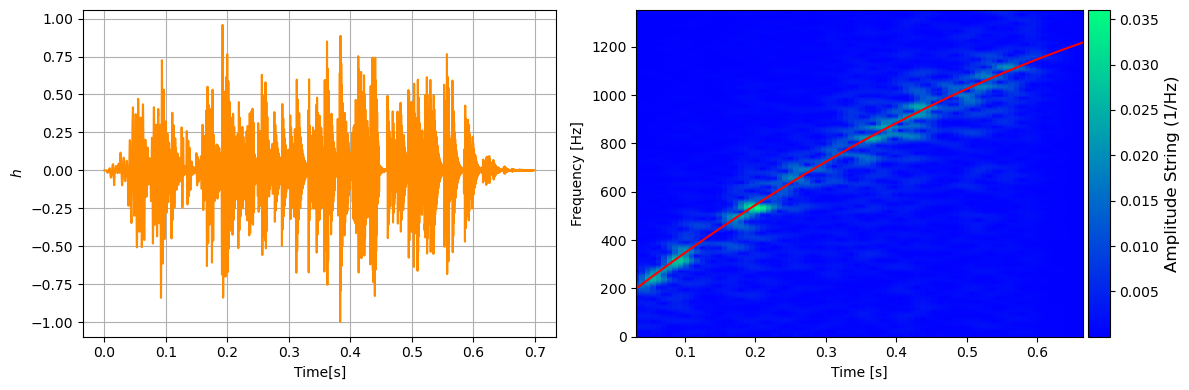

<Figure size 640x480 with 0 Axes>

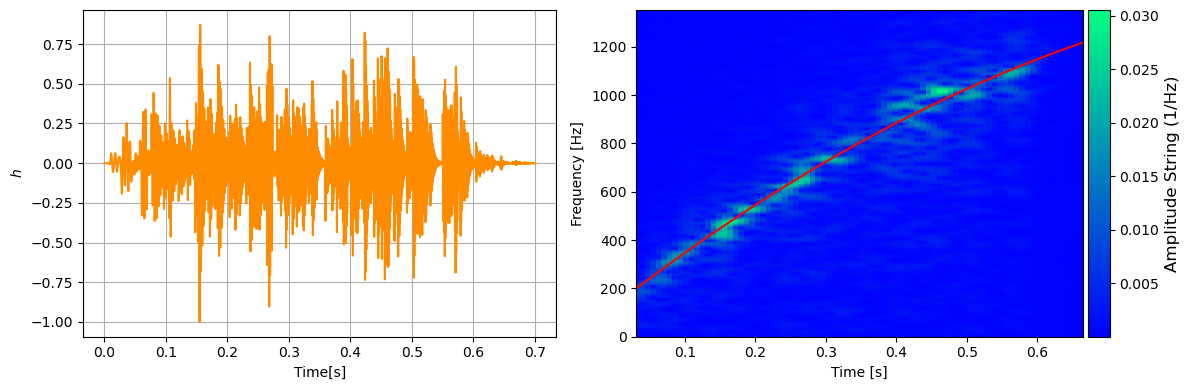

<Figure size 640x480 with 0 Axes>

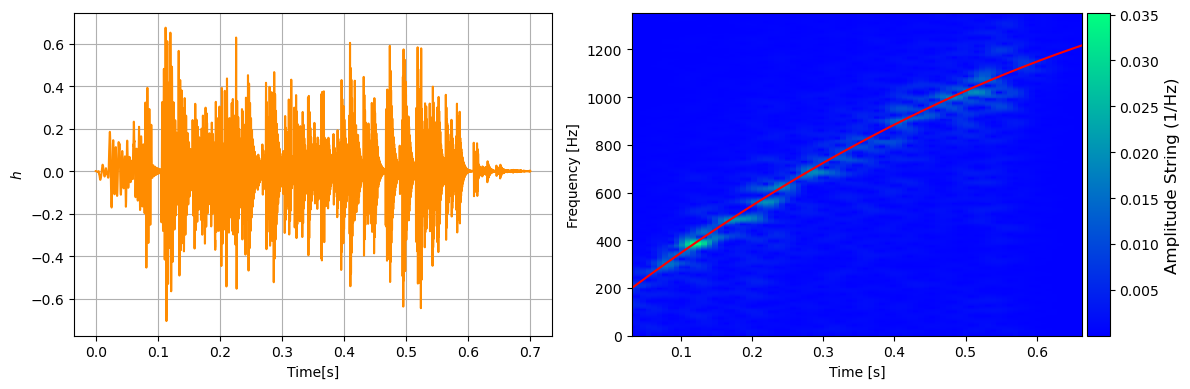

<Figure size 640x480 with 0 Axes>

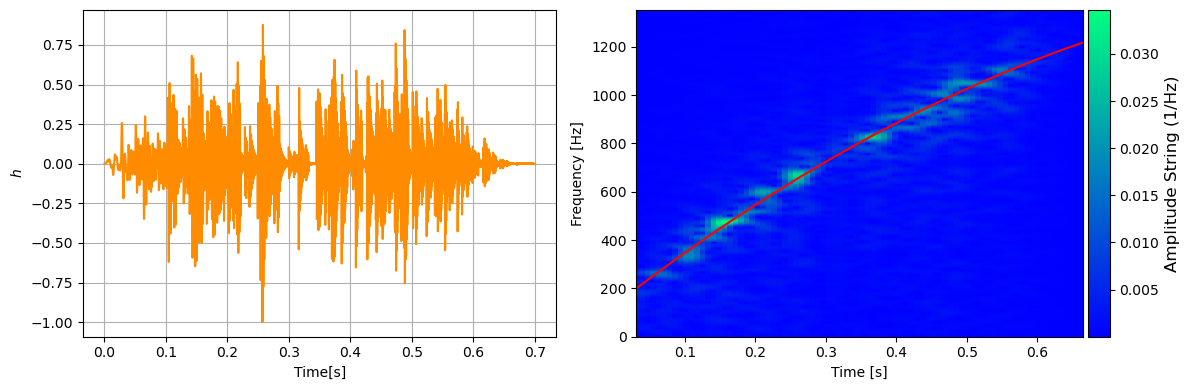

In [84]:
moder_Dur = .70
moder_f_0 = 130
moder_f_1 = 1450


L = 10
# Storage
h_storage=[]
keys = []
for i in range(0,L):
    Seed = int(time.time()/1e7 )
    Seed +=i
    #Seed = #Seed
    f=moder_f_0
    f1=moder_f_1
    H,S,Time,F = Imp(moder_Dur, moder_f_0, moder_f_1, 200, Seed)
    S = int(S)
    f = "%.2f" % f
    f1 = "%.2f" % f1
    # Storage
    h_storage.append(H)
    keys.append(f"H{i}""_Seed"f"{Seed}")
    #dat = pd.DataFrame()
    #dat["H"] = H
    #dat.to_csv(path + "run2"+f'H{i}'"_Slope"f"{S}""_f0("f"{f})""_f1("f"{f1}).csv")
    print("Slope",S,"f_0",f,"f_1",f1)
    
h = {}
for k in range(0,L):
    h[keys[k]] = h_storage[k]
data = pd.DataFrame(h)
print(data)
data.to_csv(path + "run2"+ "_Slope"f"{Seed}""_f0("f"{f})""_f1("f"{f1}).csv")

## Rapidly Rotating

In [56]:
# Generate a folder to save all the data 
# Desktop/CCSNe_Phen/H9_Slope1800_f0(127.14)_f1(1982.21).csv
import os

mainpath = r'C:\Users\PC\Desktop\CCSNe_Phen'
try:
    os.chdir(mainpath)
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except FileExistsError:
    print("The directory: {0}",path,"Already exist")
print(os.getcwd())  

# Create a folder to save all the rapidly rotating data
print(os.getcwd())
print(os.getcwd() + "\\Rapid\\")


path = os.getcwd() + "\\Rapid\\"  #"C:\\Users\\PC\\Desktop\\Tesis\\Fen_tiz\\Images\\"

try:
    os.mkdir(path)
    print("The directory: {0}",path,"Created")
except FileExistsError:
    print("The directory: {0}",path,"Already exist")




C:\Users\PC\Desktop\CCSNe_Phen
C:\Users\PC\Desktop\CCSNe_Phen
C:\Users\PC\Desktop\CCSNe_Phen\Rapid\
The directory: {0} C:\Users\PC\Desktop\CCSNe_Phen\Rapid\ Already exist


In [ ]:
# Primera forma de obtener la data
rapid_f_0 = np.linspace(100,150,200)
rapid_f_1 = np.linspace(1980,2000,200)
rapid_Dur = np.linspace(0.85,0.95,200)
#rapid_Dur = np.linspace(0.35,0.55,200)
for i in range(0,10):
    f=rapid_f_0[random.randint(0,199)]
    f1=rapid_f_1[random.randint(0,199)]
    H,S,Time,F = Imp(rapid_Dur[random.randint(0,199)], f,f1, 200, 8)
    S = int(S)
    f = "%.2f" % f
    f1 = "%.2f" % f1
    dat = pd.DataFrame()
    dat["H"] = H
    dat.to_csv(path + "run1"+f'H{i}'"_Slope"f"{S}""_f0("f"{f})""_f1("f"{f1}).csv")
    print("Slope",S,"f_0",f,"f_1",f1)

Slope 1699 f_0 120.00 f_1 1980.00
Slope 1699 f_0 120.00 f_1 1980.00
Slope 1699 f_0 120.00 f_1 1980.00
Slope 1699 f_0 120.00 f_1 1980.00
Slope 1699 f_0 120.00 f_1 1980.00
Slope 1699 f_0 120.00 f_1 1980.00
Slope 1699 f_0 120.00 f_1 1980.00
Slope 1699 f_0 120.00 f_1 1980.00
Slope 1699 f_0 120.00 f_1 1980.00
Slope 1699 f_0 120.00 f_1 1980.00
       H0_Seed1673844557  H1_Seed1673844579  H2_Seed1673844602  \
0          7.327490e-195           0.000000           0.000000   
1          8.573007e-174           0.000000           0.000000   
2          1.259143e-166           0.000000           0.000000   
3          1.128349e-159           0.000000           0.000000   
4          6.027303e-153           0.000000           0.000000   
...                  ...                ...                ...   
13922      -1.278249e-01           0.087625          -0.011478   
13923      -2.212878e-01          -0.066143          -0.056230   
13924      -2.077003e-01          -0.184217          -0.073164   


<Figure size 640x480 with 0 Axes>

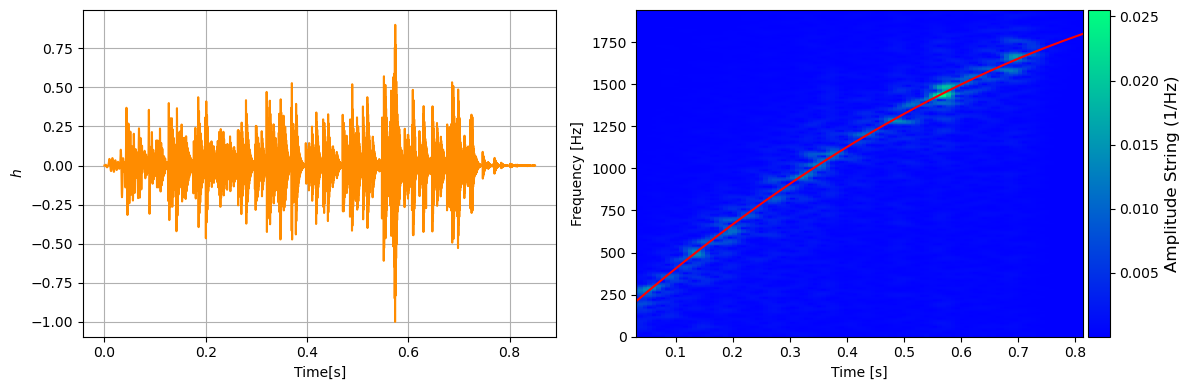

<Figure size 640x480 with 0 Axes>

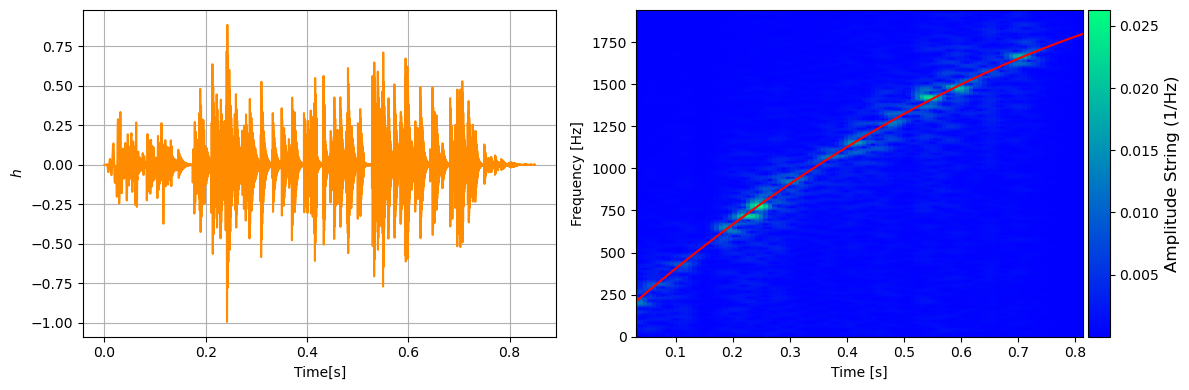

<Figure size 640x480 with 0 Axes>

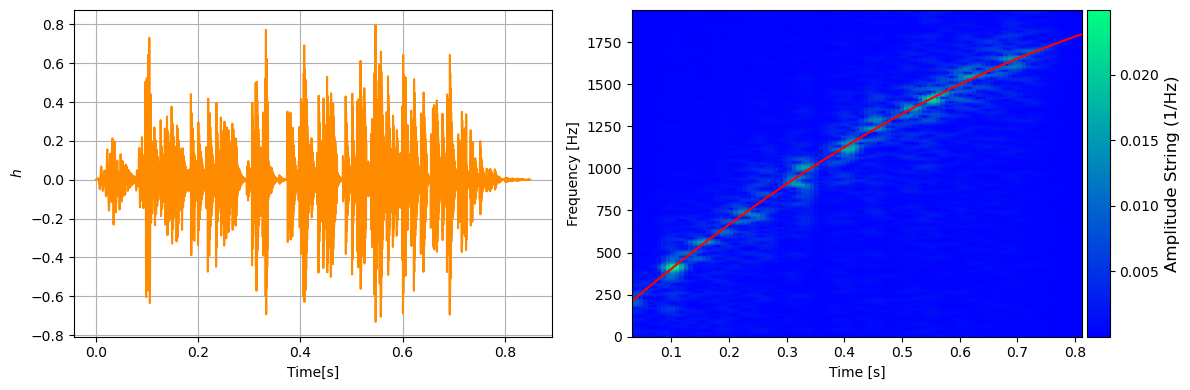

<Figure size 640x480 with 0 Axes>

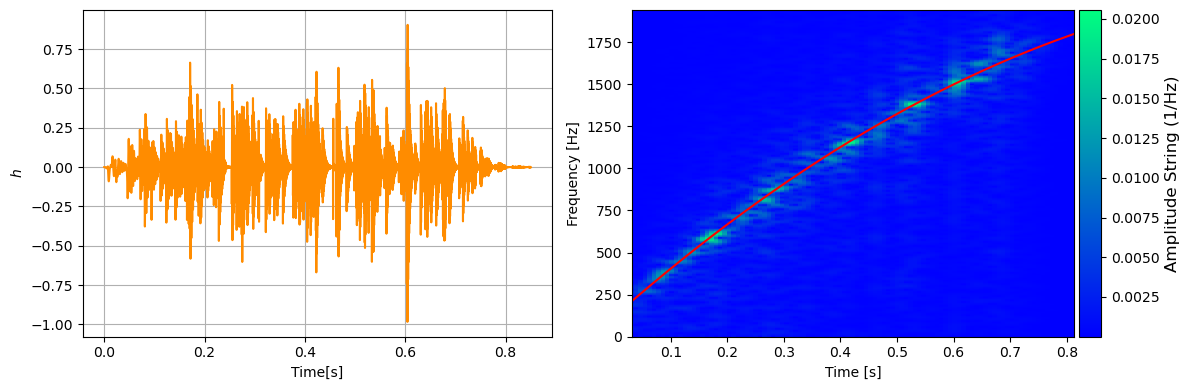

<Figure size 640x480 with 0 Axes>

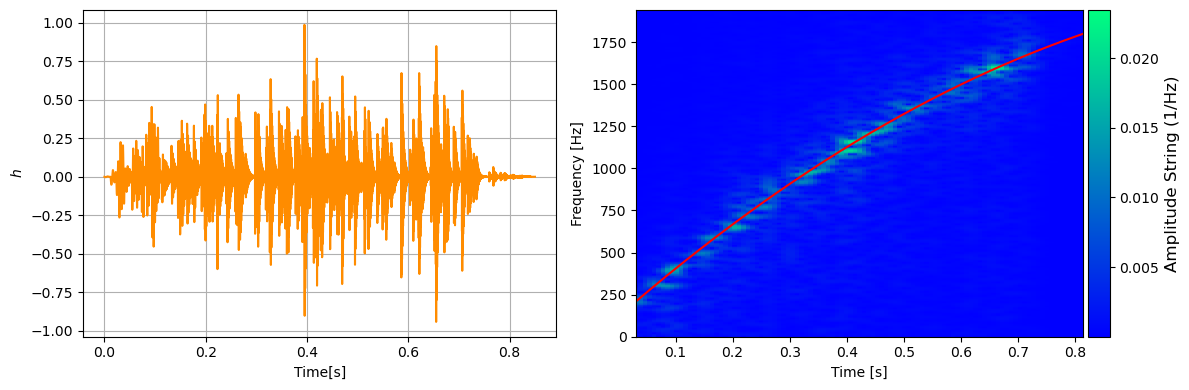

<Figure size 640x480 with 0 Axes>

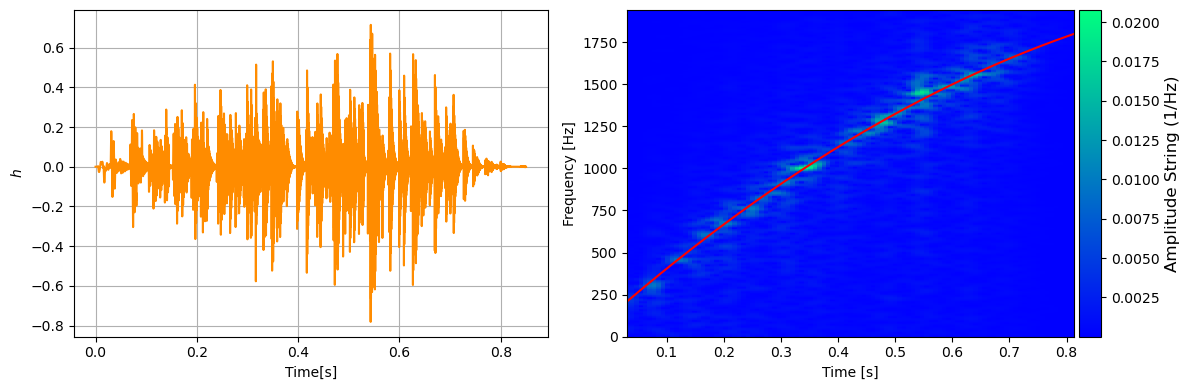

<Figure size 640x480 with 0 Axes>

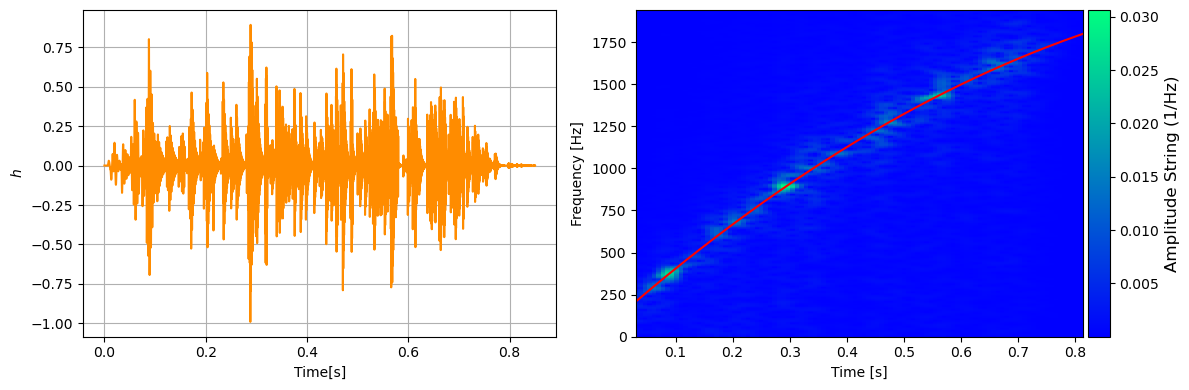

<Figure size 640x480 with 0 Axes>

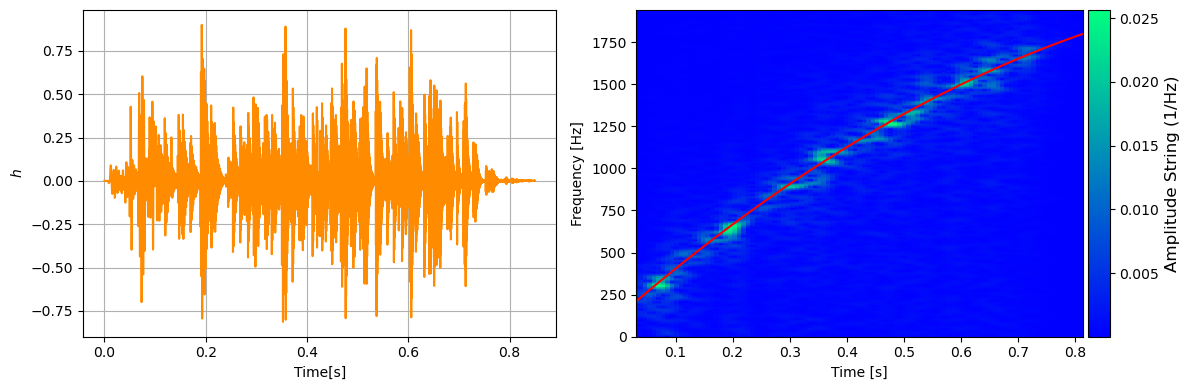

<Figure size 640x480 with 0 Axes>

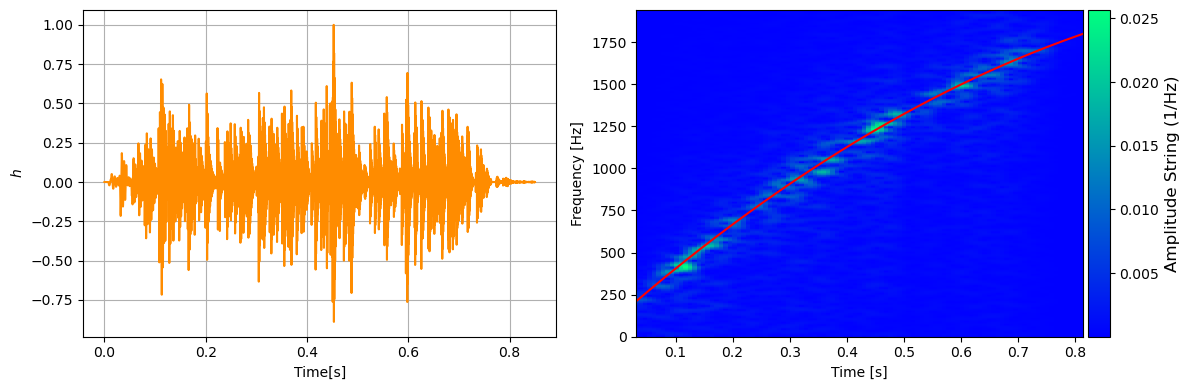

<Figure size 640x480 with 0 Axes>

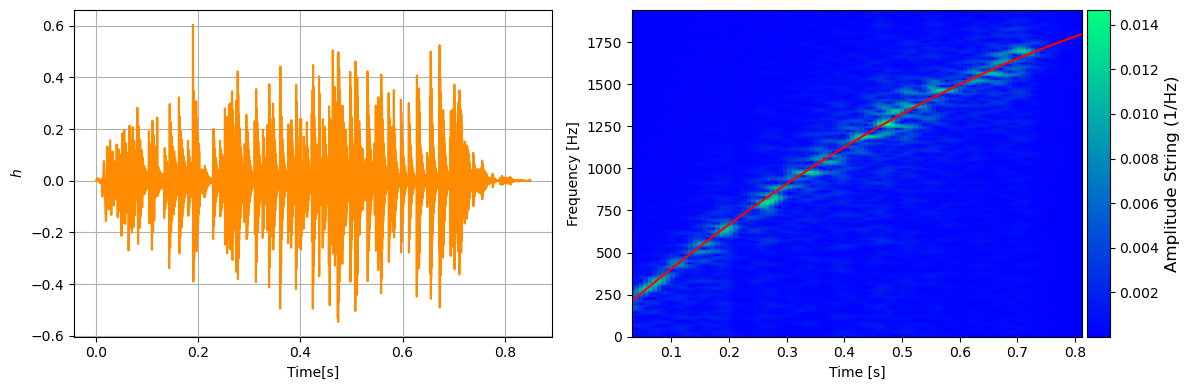

In [44]:
rapid_f_0 = 120
rapid_f_1 = 1980
rapid_Dur = 0.85


# ==========
#Numero de iteraciones
L = 10
# Storage
h_storage=[]
keys = []
for i in range(0,L):
    Seed = int(time.time())
    f=rapid_f_0
    f1=rapid_f_1
    H,S,Time,F = Imp(rapid_Dur, rapid_f_0,rapid_f_1, 200, Seed)
    S = int(S)
    f = "%.2f" % f
    f1 = "%.2f" % f1
    # Storage
    h_storage.append(H)
    keys.append(f"H{i}""_Seed"f"{Seed}")
    #dat = pd.DataFrame()
    #dat["H"] = H
    #dat.to_csv(path + "run2"+f'H{i}'"_Slope"f"{S}""_f0("f"{f})""_f1("f"{f1}).csv")
    print("Slope",S,"f_0",f,"f_1",f1)
    
h = {}
for k in range(0,L):
    h[keys[k]] = h_storage[k]
data = pd.DataFrame(h)
print(data)
data.to_csv(path + "run2"+ "_Slope"f"{S}.csv")

1.156281407035176 238.69346733668343 594.9748743718593 200 1673546282
Slope 785.54756451908
0.7100502512562814 368.3417085427136 689.9497487437186 200 1673546296
Slope 160.75858517637118
1.4396984924623115 155.7788944723618 1034.6733668341708 200 1673546312
Slope 509.3973242517882
0.4266331658291457 300.5025125628141 893.9698492462312 200 1673546326
Slope 209.8564405669508
1.0597989949748743 249.2462311557789 820.1005025125628 200 1673546341
Slope 855.7219198576812
0.571356783919598 243.21608040201005 1185.929648241206 200 1673546355
Slope 1050.314212055053
0.40854271356783917 146.73366834170855 510.5527638190955 200 1673546370
Slope 743.7091857404743
0.7341708542713568 151.25628140703517 556.2814070351759 200 1673546384
Slope 1079.1868808156025
0.8366834170854272 231.15577889447238 760.3015075376884 200 1673546399
Slope 236.5262743229843
1.2768844221105526 167.8391959798995 735.678391959799 200 1673546413
Slope 1013.1204768661248


<Figure size 432x288 with 0 Axes>

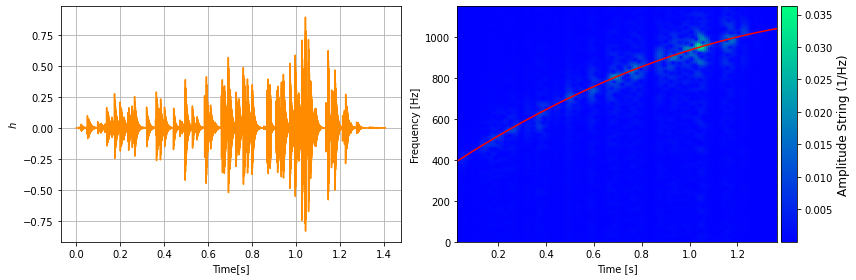

<Figure size 432x288 with 0 Axes>

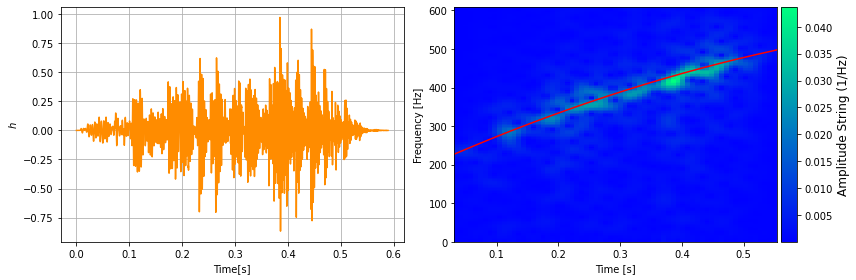

<Figure size 432x288 with 0 Axes>

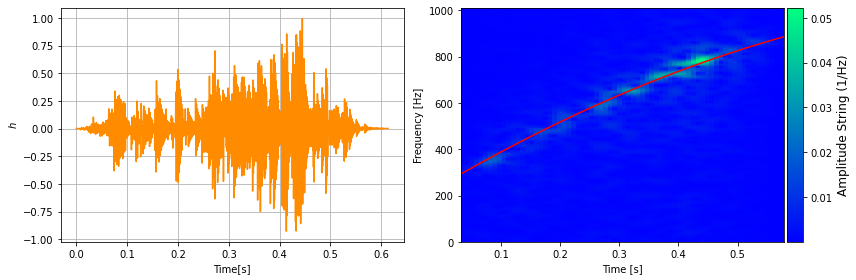

<Figure size 432x288 with 0 Axes>

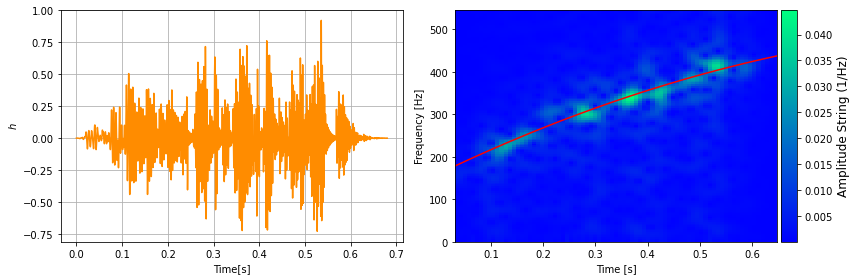

<Figure size 432x288 with 0 Axes>

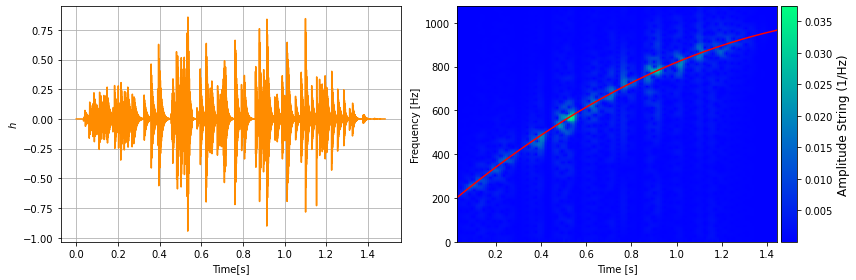

<Figure size 432x288 with 0 Axes>

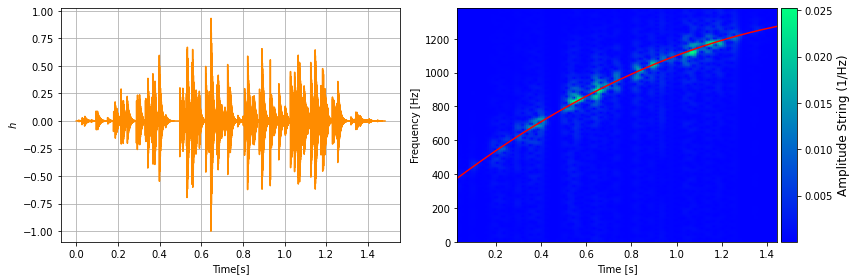

<Figure size 432x288 with 0 Axes>

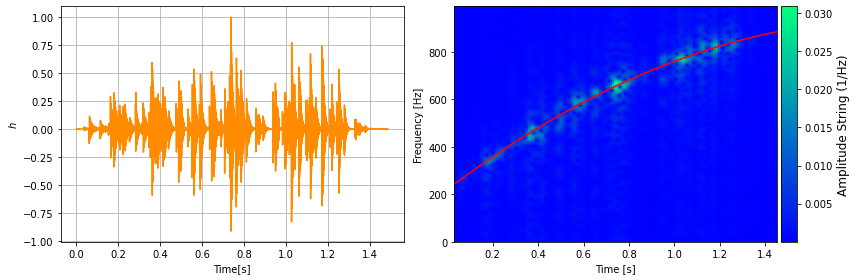

<Figure size 432x288 with 0 Axes>

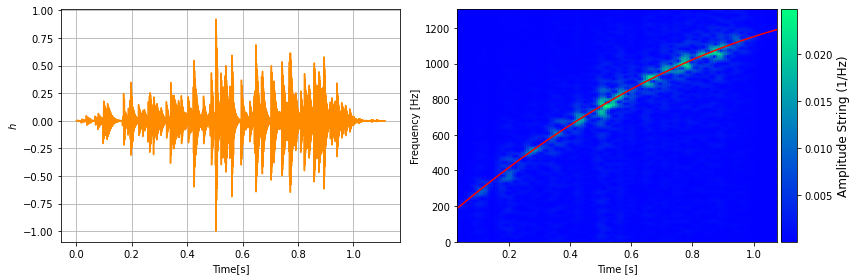

<Figure size 432x288 with 0 Axes>

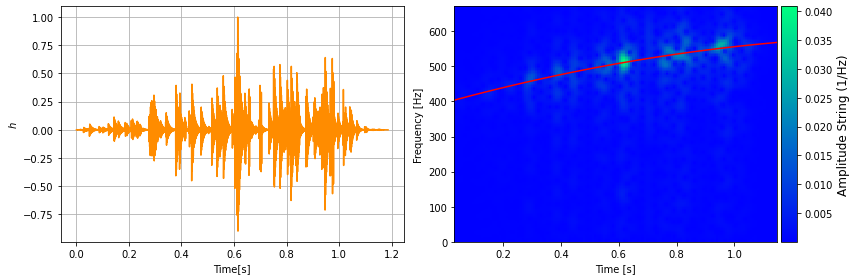

<Figure size 432x288 with 0 Axes>

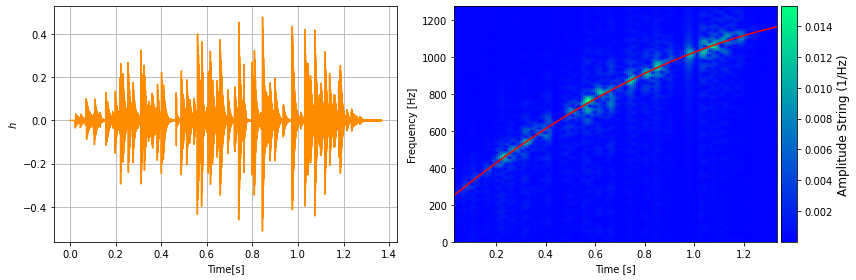

In [ ]:
# Call the function Imp(Duration,f_0,f_1,f_driver,seed)
for i in range(0,10):
  H,S,Time,F = Imp(Duration[random.randint(0,199)], f_0[random.randint(0,199)], f_1[random.randint(0,199)], 200,int(time.time()))
  print(Duration[random.randint(0,199)], f_0[random.randint(0,199)], f_1[random.randint(0,199)], 200,int(time.time()))
  print("Slope",S)

<Figure size 432x288 with 0 Axes>

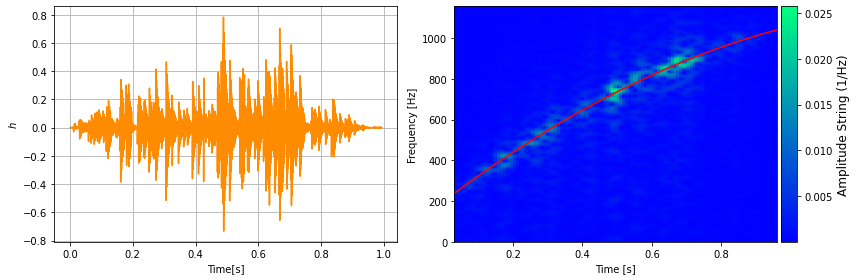

In [ ]:
# 0.993467336683417 197.98994974874373 1059.2964824120604 200 1673543024
# 0.9452261306532663 127.1356783919598 890.4522613065327 200 1673543031
# 0.8547738693467337 121.10552763819095 721.608040201005 200 1673543038
# 0.3422110552763819 291.4572864321608 732.1608040201005 200 1673543045
# 0.728140703517588 389.44723618090455 967.8391959798995 200 1673543053
# 1.071859296482412 348.7437185929648 630.1507537688442 200 1673543062
# 1.150251256281407 113.5678391959799 528.1407035175879 200 1673543069
# 1.264824120603015 252.26130653266333 1192.964824120603 200 1673543076
# 0.6798994974874372 110.55276381909547 1024.1206030150754 200 1673543083
# 0.921105527638191 205.52763819095478 742.713567839196 200 1673543090



H,S,Time,F = Imp(0.993467336683417,197.98994974874373,1059.2964824120604,200,1673543024)

          dataset       start       id         end                  segments
0    O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1256663443, 1256679418]
1    O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1256682796, 1256686818]
2    O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1256688786, 1256705153]
3    O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1256710426, 1256746767]
4    O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1256746930, 1256750703]
..            ...         ...      ...         ...                       ...
409  O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1269198850, 1269220459]
410  O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1269229591, 1269277120]
411  O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1269288626, 1269296489]
412  O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1269296653, 1269299246]
413  O3b_16KHZ_R1  1256655618  H1_DATA  1269363618  [1269305892, 1269363618]

[414 rows x 5 columns]
[1256663443, 1256679418]


ValueError: ignored

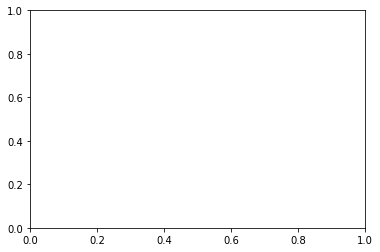

In [ ]:
# from matplotlib.axis import YAxis
# ## Leer e interpretar datos de json



# Noise = pd.read_json("Noise_H1.json")

# print(Noise)



# X = Noise["segments"]
# Y = Noise["start"]
# Z = Noise["end"]
# print(X[0])



# plt.plot(X)

# for i in range(0,413):


## Otras cosas


(8192,)
<class 'int'>
[ 9.67584026e-01  9.65990400e-01  9.64399310e-01 ...  1.21285643e-03
  6.06244335e-04 -0.00000000e+00]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.21285643e-03
  6.06244335e-04 -0.00000000e+00]


1024.0

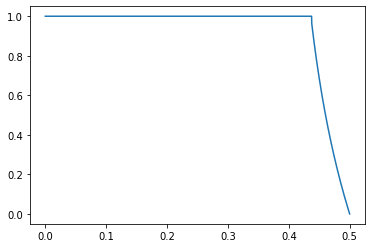

In [ ]:
# Try to made a sigmoid function

print(Time.shape)

Shape = len(Time)
Partition = int(Shape/8)
print(type(Partition))
L = np.linspace(0.38,1.0,Partition)
Log = - np.log(L)
F = np.ones(Shape - Partition)
D = np.concatenate((F,Log),axis=None)
print(Log)
print(D)
plt.plot(Time,D)
8192/8

349.996999985


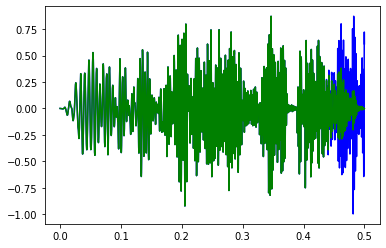

In [ ]:
print(S)
plt.plot(Time,H,color="blue")
plt.plot(Time,H*D,color="green")
# Export to json spectrogram information

[1.         0.99993896 0.99987792 ... 0.35158059 0.35147998 0.35137936]


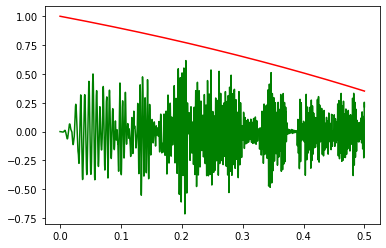

In [ ]:
#f 
#log= np.log(Time)
#f = np.log(1 - (1/Time))
#f = 1/(1 + np.exp(Time))**2
#f = 1/(1 + np.exp(-Time))
K = 1#/Time
epsT = np.exp(-K* Time)
#f = 2/(1.0 + np.exp(Time))

#f =1 + .21/log
#f =1 + Time/log
#f = 1 - (1/(1+epsT))
f = 2 - 1/(epsT)
#f =1 - (1/((1 + epsT)**5))
print(f)
#print(log)
#plt.plot(Time,H)
plt.plot(Time,f,color="red")
plt.plot(Time,H*f,color="green")
plt.show()